In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Split target variable from the rest of the dataset
y = data['Outcome']
X = data.drop('Outcome', axis=1)

# Data Preprocessing

Note that this data contains no missing values, so none need to be imputed.

In [4]:
# Sum of null values in each column
X.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

We removed outliers from the dataset by z-score. A value is considered an outlier if it is more than 3 standard deviations away from the mean.

In [5]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [6]:
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

In [7]:
X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

To help with future transforms we will convert each column to floating point values. 

In [8]:
# convert all int64 columns to float64
X.Pregnancies = X.Pregnancies.astype('float64')
X.Glucose = X.Glucose.astype('float64')
X.BloodPressure = X.BloodPressure.astype('float64')
X.SkinThickness = X.SkinThickness.astype('float64')
X.Insulin = X.Insulin.astype('float64')
X.Age = X.Age.astype('float64')

Looking at the data in a pairplot will help in determining if there are any noticeably correlated values that we would have to remove.

In [9]:
# sns.pairplot(new_X)

Note that none of the features in the dataset are strongly correlated meaning we can assume them to be independent for the sake of creating this model. We can look at the correlation coefficients for each feature to be sure. Pregnanices and Age have to strongest correlation but even then the correlation is isn't strong enough to remove. The model will perform better without the loss of information.

In [10]:
corr_mat = X.corr()
corr_mat

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.156470,0.229881,-0.097721,-0.080638,0.043549,0.015522,0.569787
Glucose,0.156470,1.000000,0.240560,0.008577,0.272654,0.196665,0.104521,0.266930
BloodPressure,0.229881,0.240560,1.000000,0.005076,-0.070572,0.274707,0.032757,0.354391
SkinThickness,-0.097721,0.008577,0.005076,1.000000,0.462778,0.383819,0.153530,-0.150039
Insulin,-0.080638,0.272654,-0.070572,0.462778,1.000000,0.165428,0.183184,-0.081003
BMI,0.043549,0.196665,0.274707,0.383819,0.165428,1.000000,0.125714,0.059980
DiabetesPedigreeFunction,0.015522,0.104521,0.032757,0.153530,0.183184,0.125714,1.000000,0.060663
Age,0.569787,0.266930,0.354391,-0.150039,-0.081003,0.059980,0.060663,1.000000


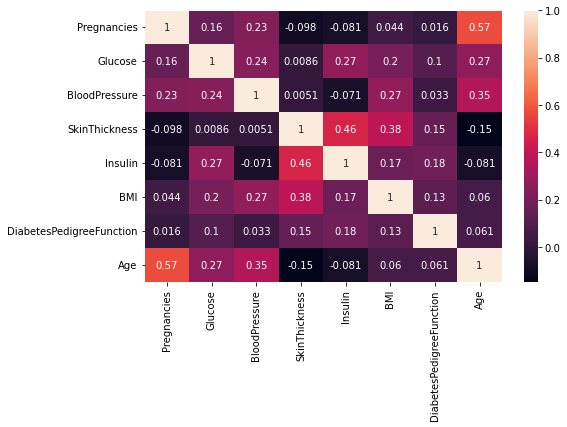

In [11]:
# create cleaner visualizations
plt.figure(figsize=(8,5))
x = sns.heatmap(corr_mat,annot=True,annot_kws={"size": 10})
x.set_yticklabels(x.get_ymajorticklabels(), fontsize = 10)
x.set_xticklabels(x.get_xmajorticklabels(), fontsize = 10)
plt.show()

The last step of ETL involves creating a train/test split to train and measure effecay of a model. In this case the test data will be a sample size 25% of the dataset. 

In [12]:
# split dataset into train and test partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

# Naive Bayes Gaussian Model (Not Tuned)

In [13]:
# build/train gaussian classifier with training data
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# print accuracy score
print('Accuracy Score : ', accuracy_score(y_test, y_pred))

Accuracy Score :  0.7616279069767442


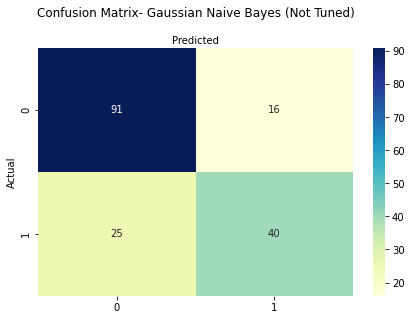

In [14]:
# create confusion matrix to visualize accuracy of the model
from sklearn import metrics

fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix- Gaussian Naive Bayes (Not Tuned)', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted');

# Naive Bayes Gaussian Model (Tuned)

In [15]:
params = {'var_smoothing': np.logspace(0,-9, num=100)}
cv_clf = GridSearchCV(estimator=clf, 
                     param_grid=params, 
                     cv=30,
                     verbose=1, 
                     scoring='accuracy')
cv_clf.fit(X_test, y_test)
y_pred = cv_clf.predict(X_test)
# print accuracy score
print('Accuracy Score : ', accuracy_score(y_test, y_pred))

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Accuracy Score :  0.7906976744186046


In [16]:
cv_clf.best_params_

{'var_smoothing': 0.02848035868435802}

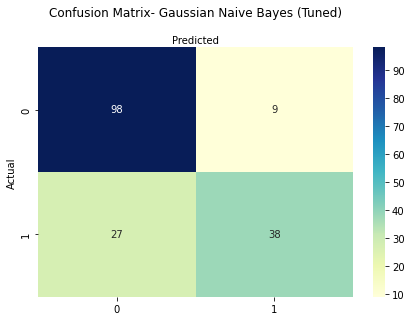

In [17]:
# create confusion matrix to visualize accuracy of the model
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix- Gaussian Naive Bayes (Tuned)', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted');

# Logistic Regression

In [18]:
reg = LogisticRegressionCV(cv=30, random_state=0, max_iter=10000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# print accuracy score
print('Accuracy Score : ', accuracy_score(y_test, y_pred))

Accuracy Score :  0.7558139534883721


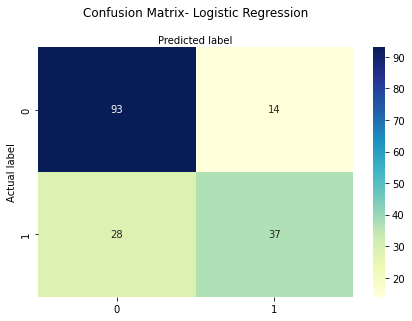

In [19]:
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix- Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');